In [1]:
import pandas as pd
import reverse_geocoder as rg
from geopy.distance import distance
import folium
from folium.plugins import HeatMap
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt




In [2]:
office_data = pd.read_csv("office_locations.csv")
log_data = pd.read_csv("datalog.csv")
empl_data = pd.read_csv("employee_details.csv")
dept_data = pd.read_csv("dept_resources.csv")



1.1 Hypothesis Is it possible to identify anomalous login locations for employees by comparing their login locations with their home and office addresses, as well as the headquarter (HQ), Paris, London, and Luxembourg locations, and flagging any logins that occur outside of a 10-mile radius of these known locations as suspicious

Task 1.2

In [3]:
emp_data = empl_data.rename(columns={'Home Latitude': 'Latitude'})
emp_data = emp_data.rename(columns={'Home Longitude': 'Longitude'})
office_data_col = office_data[['Longitude', 'Latitude']]
emp_data_col = emp_data[['Longitude', 'Latitude']]
df_concatenated = pd.concat([office_data_col, emp_data], axis=0)


In [4]:
log_data = log_data.dropna(subset=['Latitude', 'Longitude'])
df_concatenated = df_concatenated.dropna(subset=['Latitude', 'Longitude'])

location_coords = np.array([(lat, lon) for lat, lon in zip(log_data['Latitude'], log_data['Longitude'])])
point_coords = np.array([(lat, lon) for lat, lon in zip(df_concatenated['Latitude'], df_concatenated['Longitude'])])


tree = BallTree(point_coords, metric='haversine')

distances, indices = tree.query(location_coords, k=10)

within_ten_miles = [any(distance(location_coord, point_coords[index]).miles <= 10 for index in indices[i]) for i, location_coord in enumerate(location_coords)]

log_data['Within Ten Miles'] = within_ten_miles


In [5]:
log_data_false = log_data[log_data['Within Ten Miles'] == False]
result_counts = log_data_false.groupby(['Latitude', 'Longitude'])['Within Ten Miles'].count()
print("Number of Access Attempts outside 10 miles per location")
for loc, count in result_counts.items():
    print(f"({loc[0]}, {loc[1]}): {count}")
heatmap_data = log_data_false[['Latitude', 'Longitude']].values.tolist()
heatmap = HeatMap(heatmap_data)


m = folium.Map(location=[0, 0], zoom_start=2)

heatmap.add_to(m)


m.fit_bounds([[min(heatmap_data), min(heatmap_data)], [max(heatmap_data), max(heatmap_data)]])

num_points = len(heatmap.data)
print(f'Number of points in heatmap: {num_points}')

m


Number of Access Attempts outside 10 miles per location
(33.137223, 101.900907): 120
(33.145223, 100.900907): 1
(33.213448, 120.302408): 39
(33.213448, 122.302408): 12
(34.84486707, -80.78744262): 14
(34.8453955, -80.77825209): 14
(34.84668176, -80.83799059): 15
(34.85519235, -80.71968366): 16
(34.85639439, -80.88719915): 16
(34.85639439, -80.71531333): 14
(34.85898569, -80.89586056): 14
(34.86160778, -80.95628358): 1
(34.86197082, -80.90567981): 14
(34.86239962, -80.9654481): 14
(34.86278982, -80.78715838): 16
(34.86289403, -80.97001646): 14
(34.86328543, -80.77335007): 12
(34.86394566, -80.76417003): 12
(34.86404994, -80.71464693): 11
(34.8640791, -80.88743131): 14
(34.86428118, -80.71924604): 14
(34.86444363, -80.93934929): 15
(34.86542875, -80.83306559): 15
(34.86605394, -80.7459211): 11
(34.86606132, -80.9715239): 13
(34.86615834, -80.76789361): 1
(34.8662575, -80.7540722): 14
(34.86642272, -80.77710324): 12
(34.8665369, -80.68552155): 13
(34.86674423, -80.84214152): 15
(34.866951

Task 2.1 Can anomalous resource accesses be detected by comparing an employee's department with the department(s) that the accessed resource(s) belong to, and flagging any accesses that occur outside of the employee's work department as suspicious?

Task 2.2 

In [6]:
log_data_false_access = log_data_false[log_data_false['Action'] == 'access']
merged_dat = pd.merge(empl_data, log_data_false_access, on='EmployeeID', how='inner')

merged_data = merged_dat[merged_dat['Result'] =='failed']
result_counts = merged_data.groupby('Name')['Result'].count()
print("Number of Failed Access Attempts per employee")
for name, count in result_counts.items():
    print(f"{name}: {count}")


Number of Failed Access Attempts per employee
Adara: 10
Chiquita: 30
Inez: 10
Silas: 35


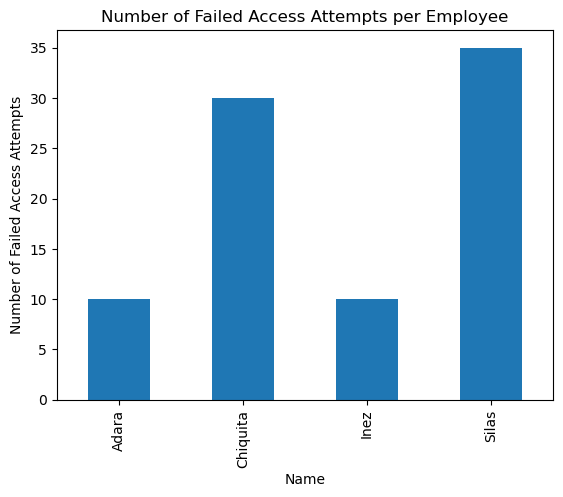

In [7]:
access_counts = merged_data.groupby(['Name', 'Result'])['Result'].count().unstack()
access_counts['failed'].plot(kind='bar')
plt.title('Number of Failed Access Attempts per Employee')
plt.ylabel('Number of Failed Access Attempts')
plt.show()

Loading formatted geocoded file...
Number of Failed Access Attempts per country
CN: 85


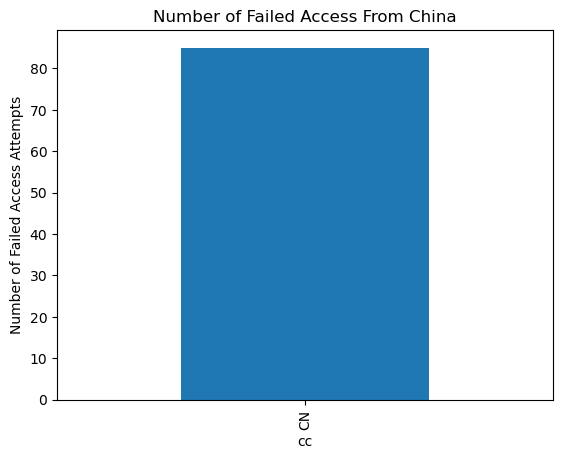

In [8]:
coordinates = [(lat, lon) for lat, lon in merged_data[['Latitude', 'Longitude']].values]

def get_country(coordinates):
    locations = rg.search(coordinates)
    return [loc['cc'] for loc in locations]

country_codes = get_country(coordinates)

merged_data = merged_data.copy()
merged_data['cc'] = country_codes


access_count = merged_data.groupby(['cc', 'Result'])['Result'].count().unstack()

result_counts = merged_data.groupby('cc')['Result'].count()
print("Number of Failed Access Attempts per country")
for cc, count in result_counts.items():
    print(f"{cc}: {count}")

access_count['failed'].plot(kind='bar')
plt.title('Number of Failed Access From China')
plt.ylabel('Number of Failed Access Attempts')
plt.show()




Task 3.1 Is it possible to identify incidents of unauthorized access to company resources by former employees by comparing the timestamps of resource access attempts with the employee's termination date, and flagging any access attempts that occur after the termination date as suspicious?





Task 3.2

Number of Unauthorized Access Attempts per employee
Addison: 7
Desirae: 15
Leo: 15
Nyssa: 6


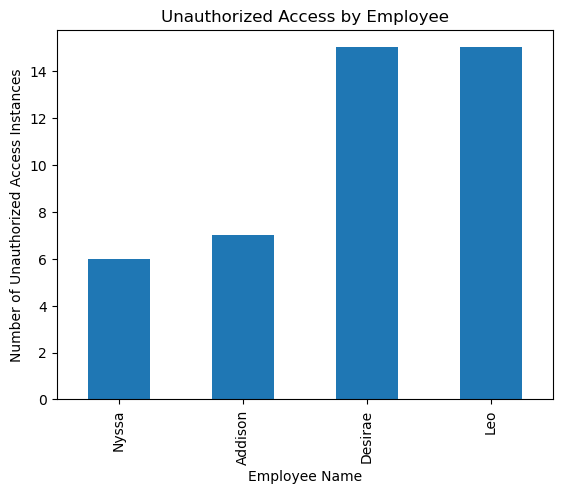

In [9]:
access_data = pd.merge(log_data, emp_data, on='EmployeeID', how='inner' )



access_data['Datetime'] = pd.to_datetime(access_data['Datetime'])
access_data['End Date'] = pd.to_datetime(access_data['End Date'])


access_data['Unauthorized'] = access_data['Datetime'] > access_data['End Date']


access_data = access_data[access_data['Unauthorized'] == True]

result_counts = access_data.groupby('Name')['Unauthorized'].count()
print("Number of Unauthorized Access Attempts per employee")
for name, count in result_counts.items():
    print(f"{name}: {count}")

unauth_counts = access_data.groupby('Name')['Unauthorized'].apply(lambda x: sum(x==True)).sort_values()

unauth_counts.plot(kind='bar', x=unauth_counts.index, y=unauth_counts.values)

plt.title('Unauthorized Access by Employee')
plt.xlabel('Employee Name')
plt.ylabel('Number of Unauthorized Access Instances')
plt.show()

